## 1. package import 

In [2]:
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, schedule_function,date_rules, time_rules
from datetime import datetime
import pyfolio as pf

import pandas as pd

## 2. func

In [3]:
def initialize(context):
    # Which stocks to trade
    dji = [
        "AAPL",
        "AXP",
        "BA",
        "CAT",
        "CSCO",
        "CVX",
        "DIS",
        "DWDP",
        "GS",
        "HD",
        "IBM",
        "INTC",
        "JNJ",
        "JPM",
        "KO",
        "MCD",
        "MMM",
        "MRK",
        "MSFT",
        "NKE",
        "PFE",
        "PG",
        "TRV",
        "UNH",
        "UTX",
        "V",
        "VZ",
        "WBA",
        "WMT",
        "XOM",  
    ]
    
    # 티커로부터 심볼 리스트 만들기
    context.universe = [symbol(s) for s in dji]
    # 히스토리 윈도우
    context.history_window = 20  # 약 한달 간, 20일
    #포트폴리오 크기
    context.stocks_to_hold = 10  #홀드(매수)하는 주식 수
    #한 달에 한 번만 거래 함
    schedule_function(handle_data, date_rules.month_start(), time_rules.market_close())

In [4]:
# def month_perf(ts):
#     perf = (ts[-1]/ ts[0] - 1)
#     return perf
def month_perf(ts):
    perf = (ts.iloc[-1] / ts.iloc[0] - 1)
    return perf

In [5]:
def handle_data(context, data):
    hist = data.history(context.universe, "close", context.history_window, "1d")
    perf_table = hist.apply(month_perf).sort_values(ascending=False) # 가장 높은 성과를 가지는 포트폴리오 순서로 정렬
    buy_list= perf_table[:context.stocks_to_hold]  #홀드(매수) 주식 계획에 따라 매수 리스트 생성
    the_rest = perf_table[context.stocks_to_hold:]  #홀드 이외에는 버림
    
    for stock, perf in buy_list.items():  #홀드(매수) 주식 계획에 따라 포트 폴리오 비중 조정
        stock_weight = 1 / context.stocks_to_hold
        if data.can_trade(stock):order_target_percent(stock, stock_weight)
            
    for stock, perf in the_rest.items(): #홀드(매수) 주식 계획에 따라 포트 폴리오 비중 조정
        if data.can_trade(stock): order_target_percent(stock, 0.0)

In [6]:
def analyze(context, perf):
    returns, postions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf) #수익률, 포지션, 거래 반환
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)

## 3. Run

In [7]:
# start = pd.Timestamp('2003-1-1', tz='utc')
# end = pd.Timestamp('2017-12-31', tz='utc')
start = pd.Timestamp('2003-1-1')
end = pd.Timestamp('2017-12-31')

## 전략의 성과
### 핵심 비율(key ratio)
- 연간 수익률: 일반적으로 높으 수익률이 낮은 수익률보다 낫지만, 수익률 만으로는 맥락을 알 수 없다.
- 연간 변동성(YV), 샤프비율(SR), 최대 손실낙폭(MDD): 이러한 수치들은 변동성과 하향 위험을 고려한다.
- 현실에서 연간 15% 이상의 수익률을 보일 가능성은 낮고, 샤프 비율이 1%를 넘을 가능성을 낮으며 장기 수익률의 세 배의 최대 손실폭을 보일 수도 있다. 이를 넘어서는 백테스트는 문제가 있다고 볼 수 있고, 현실에서 달성할 수 있는 수치가 아니다.

### 손실 테이블 (drawdown table)
- 상위 5개 손실 기간 (drawdown period), 손실 퍼센트(percent loss), 날짜(dates) 및 회복 시간(recovery time)을 보여준다.

- Annual Return(연간 수익률): 연간 투자 가치  
- Cumulative Returns(누적 수익률) : 전체 기간의 누적 수익  
- Annual Volatility(연간 변동성): 연간 수익의 표준편차  
- Sharpe Ratio(샤프 비율):위험 조정 수익의 측정치, 위험 단위당 초과 수익  
- Calmar Ratio(칼마 비율): 연간 수익을 최대 손실에서 나눈 비율, 큰 하락 위험에 대한 return의 측정치 제공, 높은 Calmar Ratio는 높은 수익과 낮은 최대 손실을 의미  
- Stability(안정성): 수익의 일관성, 더 높은 안정성은 시간에 걸쳐 더 일관된 수익을 나타냄  
- Max Drawdown(최대 손실): 전략의 위험, 최대 손실은 투자 전략이 특정 기간 동안 얼마나 크게 손실을 겪었는지를 나타냄   
- Omega Ratio(오메가 비율): 수익 분포와 투자자의 위험 회피도를 모두 고려한 위험 대비 수익. 1보다 크면 예상 손실보다 예상 이익이 크다는 것을 의미. 예를 들어, Omega Ratio가 1.12이면 투자 전략에서 기대 수익이 예상 손실보다 12% 높다는 것  
- Sortino Ratio(소르티노 비율):샤프 비율과 유사하게 위험 조정 수익을 측정하지만 하향 위험만 고려 (총 변동성 대신 하향 편차를 사용), 높은 Sortino Ratio는 더 안정적인 하락 리스크에 대한 수익을 나타냄   
- Skew(왜도): 왜도는 수익 분포의 비대칭성을 측정, 양의 왜도는 오른쪽 꼬리가 늘어진 분포를 나타냄  
- Kurtosis(척도): 척도는 수익 분포의 "꼬리 두께"를 측정, 높은 척도는 더 두터운 꼬리와 더 극단적인 값을 나타낼 수 있음  
- Tail Ratio(테일 비율): 극단적인 이벤트에 대한 리스크를 측정  
- Daily Value at Risk (VaR) (일일 위험 가치): VaR은 특정 신뢰 수준에서의 최대 잠재적 손실을 측정, 일일 기대 손실을 나타냄  47%):

| Worst Drawdown Periods (최악의 손실 기간) | Net Drawdown (순 최대 손실 %): | Peak Date   (최고점 날짜) | Valley Date  (저점 날짜)| Recovery Date (회복 날짜)| Duration  (기간)|
|------------------------|------------------:|-------------|-------------|---------------|----------|
| 최악의 손실이 발생한 특정 기간  | 최악의 손실 기간 동안의 순 최대 손실을 백분율 | 최악의 손실이 시작된 시점에서의 투자 가치의 최고점이었던 날짜 | 최악의 손실이 가장 큰 때의 투자 가치가 최저점에 도달한 날짜  | 손실에서 회복되어 다시 이익이 발생한 날짜   | 최악의 손실 기간의 길이    |



C:\Users\taest\miniconda3\envs\mlft310\lib\site-packages\zipline\finance\ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns
C:\Users\taest\miniconda3\envs\mlft310\lib\site-packages\pyfolio\plotting.py:666: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.606%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2003-01-02
End date,2017-12-29
Total months,179
,Backtest
Annual return,9.606%
Cumulative returns,295.256%
Annual volatility,18.176%
Sharpe ratio,0.60
Calmar ratio,0.17
Stability,0.78
Max drawdown,-58.17%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,58.17,2007-10-31,2009-03-09,2013-03-22,1408
1,12.98,2015-07-16,2015-08-25,2016-03-11,172
2,11.09,2004-03-05,2004-08-06,2004-10-06,154
3,10.16,2007-07-19,2007-08-16,2007-10-29,73
4,10.00,2003-01-06,2003-03-11,2003-03-21,55


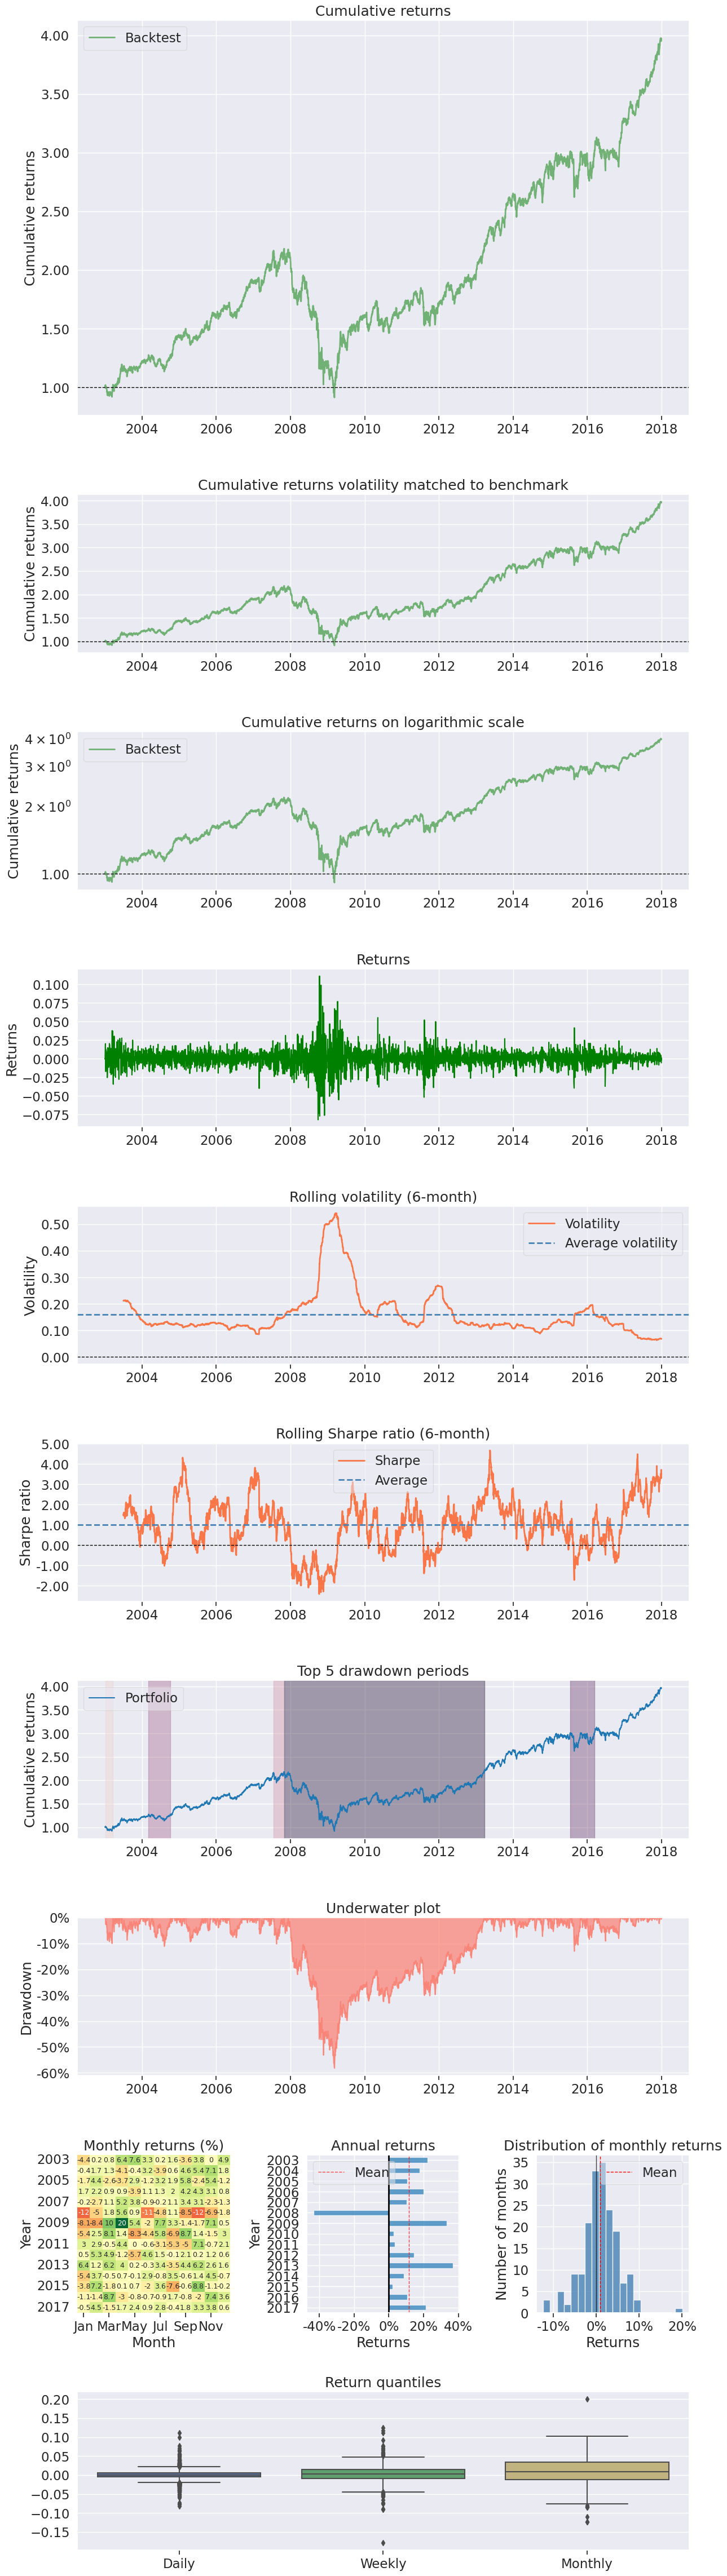

In [8]:
result = run_algorithm(
        start=start,
        end=end,
        initialize=initialize,
        analyze=analyze,
        capital_base=10000,
        data_frequency='daily',
        bundle='quandl')

## result의 데이터 종류

In [9]:
result.head()

,period_open,period_close,positions,net_leverage,transactions,gross_leverage,orders,returns,short_value,capital_used,...,beta,trading_days,benchmark_period_return,benchmark_volatility,max_leverage,max_drawdown,period_label,sortino,sharpe,treasury_period_return
2003-01-02 00:00:00+00:00,2003-01-02 14:31:00+00:00,2003-01-02 21:00:00+00:00,[],0.000000,[],0.000000,"[{'id': '601478fb35a14b59be654de6a4b5571d', 'd...",0.000000,0.0,0.000000,...,None,1,0.0,NaN,0.000000,0.000000,2003-01,NaN,NaN,0.0
2003-01-03 00:00:00+00:00,2003-01-03 14:31:00+00:00,2003-01-03 21:00:00+00:00,"[{'sid': Equity(1576 [JPM]), 'amount': 39, 'co...",0.979858,"[{'amount': 39, 'dt': 2003-01-03 21:00:00+00:0...",0.979858,"[{'id': '601478fb35a14b59be654de6a4b5571d', 'd...",-0.000513,0.0,-9798.679775,...,None,2,0.0,0.0,0.979858,-0.000513,2003-01,-11.224972,-11.224972,0.0
2003-01-06 00:00:00+00:00,2003-01-06 14:31:00+00:00,2003-01-06 21:00:00+00:00,"[{'sid': Equity(1576 [JPM]), 'amount': 39, 'co...",0.980258,[],0.980258,[],0.020296,0.0,0.000000,...,None,3,0.0,0.0,0.980258,-0.000513,2003-01,353.462225,8.819963,0.0
2003-01-07 00:00:00+00:00,2003-01-07 14:31:00+00:00,2003-01-07 21:00:00+00:00,"[{'sid': Equity(1576 [JPM]), 'amount': 39, 'co...",0.980059,[],0.980059,[],-0.009977,0.0,0.000000,...,None,4,0.0,0.0,0.980258,-0.009977,2003-01,7.791693,3.052444,0.0
2003-01-08 00:00:00+00:00,2003-01-08 14:31:00+00:00,2003-01-08 21:00:00+00:00,"[{'sid': Equity(1576 [JPM]), 'amount': 39, 'co...",0.979715,[],0.979715,[],-0.017000,0.0,0.000000,...,None,5,0.0,0.0,0.980258,-0.026807,2003-01,-2.589843,-1.624639,0.0


In [10]:
for column in result:
    print(column)

period_open
period_close
positions
net_leverage
transactions
gross_leverage
orders
returns
short_value
capital_used
shorts_count
long_value
ending_value
starting_exposure
longs_count
short_exposure
ending_cash
portfolio_value
starting_cash
pnl
long_exposure
ending_exposure
starting_value
excess_return
algorithm_period_return
algo_volatility
alpha
beta
trading_days
benchmark_period_return
benchmark_volatility
max_leverage
max_drawdown
period_label
sortino
sharpe
treasury_period_return


- **period_open:** 주어진 기간의 시작 시간
- **period_close:** 주어진 기간의 종료 시간
- **positions:** 주어진 시간에 보유 중인 자산의 포지션
- **net_leverage:** 보유 중인 자산의 순 가치에 대한 지불 가능한 자금의 비율
- **transactions:** 해당 기간 동안의 거래 내역
- **returns:** 주어진 기간 동안의 수익률
- **gross_leverage:** 보유 중인 자산의 총 가치에 대한 지불 가능한 자금의 비율
- **starting_exposure:** 주어진 기간의 시작 시점에서의 자산 가치
- **orders:** 해당 기간 동안의 주문 내역
- **short_value:** 보유 중인 공매도 중인 자산의 가치
- **long_value:** 보유 중인 매수 중인 자산의 가치
- **ending_value:** 주어진 기간의 종료 시점에서의 자산 가치
- **longs_count:** 보유 중인 매수 중인 자산의 수
- **capital_used:** 주어진 기간 동안 사용된 자본
- **short_exposure:** 주어진 기간 동안의 공매도 중인 자산에 대한 노출(가치)
- **ending_cash:** 주어진 기간의 종료 시점에서의 현금 잔액
- **portfolio_value:** 주어진 기간의 종료 시점에서의 포트폴리오 가치
- **starting_cash:** 주어진 기간의 시작 시점에서의 현금 잔액
- **pnl:** 주어진 기간 동안의 손익
- **long_exposure:** 주어진 기간 동안의 매수 중인 자산에 대한 노출(가치)
- **ending_exposure:** 주어진 기간의 종료 시점에서의 자산 노출(가치)
- **starting_value:** 주어진 기간의 시작 시점에서의 포트폴리오 가치
- **shorts_count:** 보유 중인 공매도 중인 자산의 수
- **excess_return:** 투자 전략의 수익률이 벤치마크 대비 얼마나 초과했는지
- **algorithm_period_return:** 주어진 알고리즘의 수익률
- **algo_volatility:** 알고리즘의 변동성
- **alpha:** 알고리즘의 알파 값
- **beta:** 알고리즘의 베타 값
- **trading_days:** 주어진 기간 동안의 거래일 수
- **period_label:** 주어진 기간의 라벨 또는 이름
- **max_drawdown:** 주어진 기간 동안의 최대 손실
- **benchmark_period_return:** 벤치마크의 수익률
- **benchmark_volatility:** 벤치마크의 변동성
- **max_leverage:** 주어진 기간 동안의 최대 레버리지
- **sortino:** Sortino 비율
- **sharpe:** Sharpe 비율
- **treasury_period_return:** 주어진 기간 동안의 국채 수익률


### 특정 일의 포지션 스냅샷

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
day = '2009-03-20'

In [13]:
port_value = result.loc[day,'portfolio_value']
day_positions = result.loc[day,'positions']

In [14]:
df = pd.DataFrame(columns=['value', 'pnl'])

In [15]:
for pos in day_positions:
    ticker = pos['sid'].symbol 
    df.loc[ticker,'value'] = pos['amount'] * pos['last_sale_price']
    df.loc[ticker,'pnl'] = df.loc[ticker,'value'] - (pos['amount'] * pos['cost_basis'])
    
# 현금 포지션 추가
# df.loc['cash', ['value','pnl']] = [(port_value - df['value'].sum()), 0]    
    

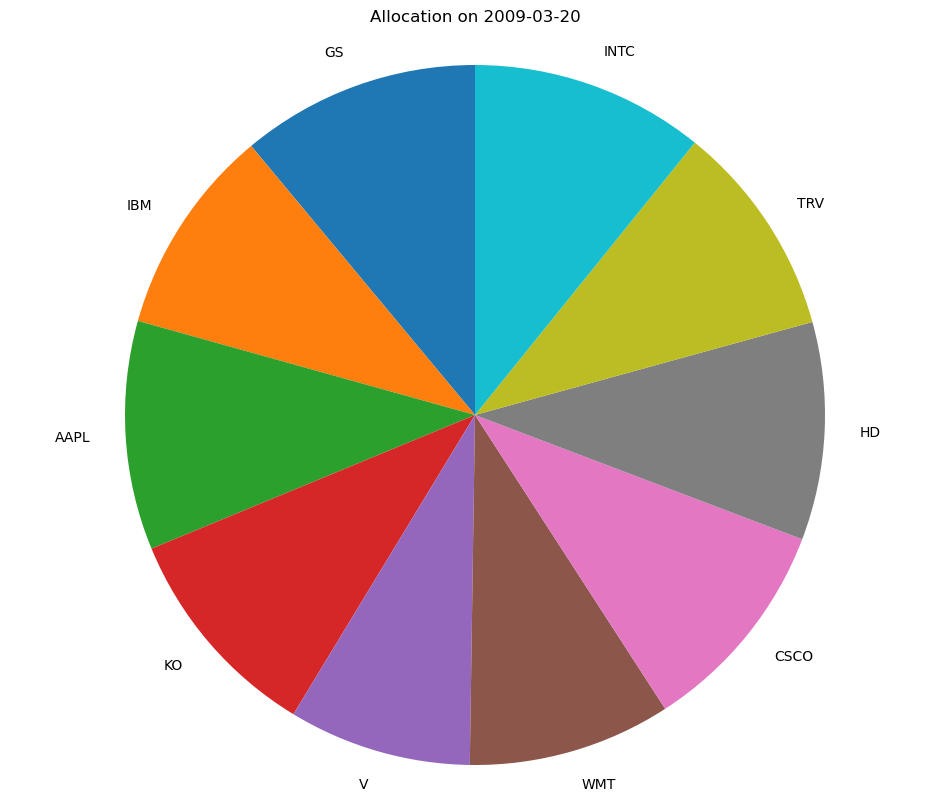

In [16]:
# Make pie chart for allocations
fig, ax1 = plt.subplots(figsize=[12, 10])
ax1.pie(df['value'], labels=df.index, shadow=False, startangle=90)
ax1.axis('equal')
ax1.set_title('Allocation on {}'.format(day))
plt.show()

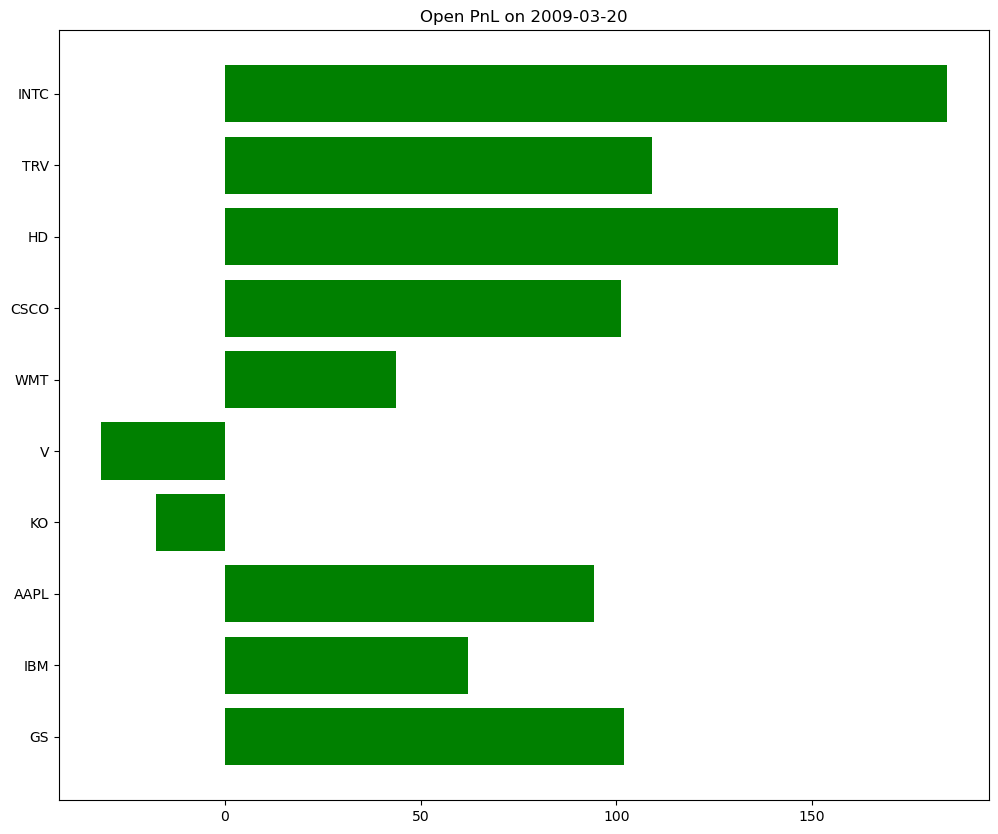

In [17]:
# Make bar chart for open PnL
fig, ax1 = plt.subplots(figsize=[12, 10])
# pnl_df = df.drop('cash')
pnl_df = df
ax1.barh( pnl_df.index, pnl_df['pnl'],  align='center', color='green', ecolor='black')
ax1.set_title('Open PnL on {}'.format(day))
plt.show()

### 시계열 분석

In [18]:
import numpy as np
import pandas as pd

from matplotlib import pyplot, rc, ticker

In [19]:
font = {'family': 'sans-serif',
        'weight': 'normal',
         'size': 16}
rc('font', **font)

calc_window = 126 # 반년의 거래 일 수
year_length = 252 # 1년의 거래 일 수

# 필요한 열을 복사 한다. ('portfolio_value', 'gross_leverage')
df = result.copy().filter(items=['portfolio_value', 'gross_leverage'])

# 연간 수익률 계산
def ann_ret(ts):
    return np.power((ts.iloc[-1] / ts.iloc[0]), (year_length / len(ts))) - 1


# MDD 계산
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

rolling_window = result.portfolio_value.rolling(calc_window)

df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

df.dropna(inplace=True)



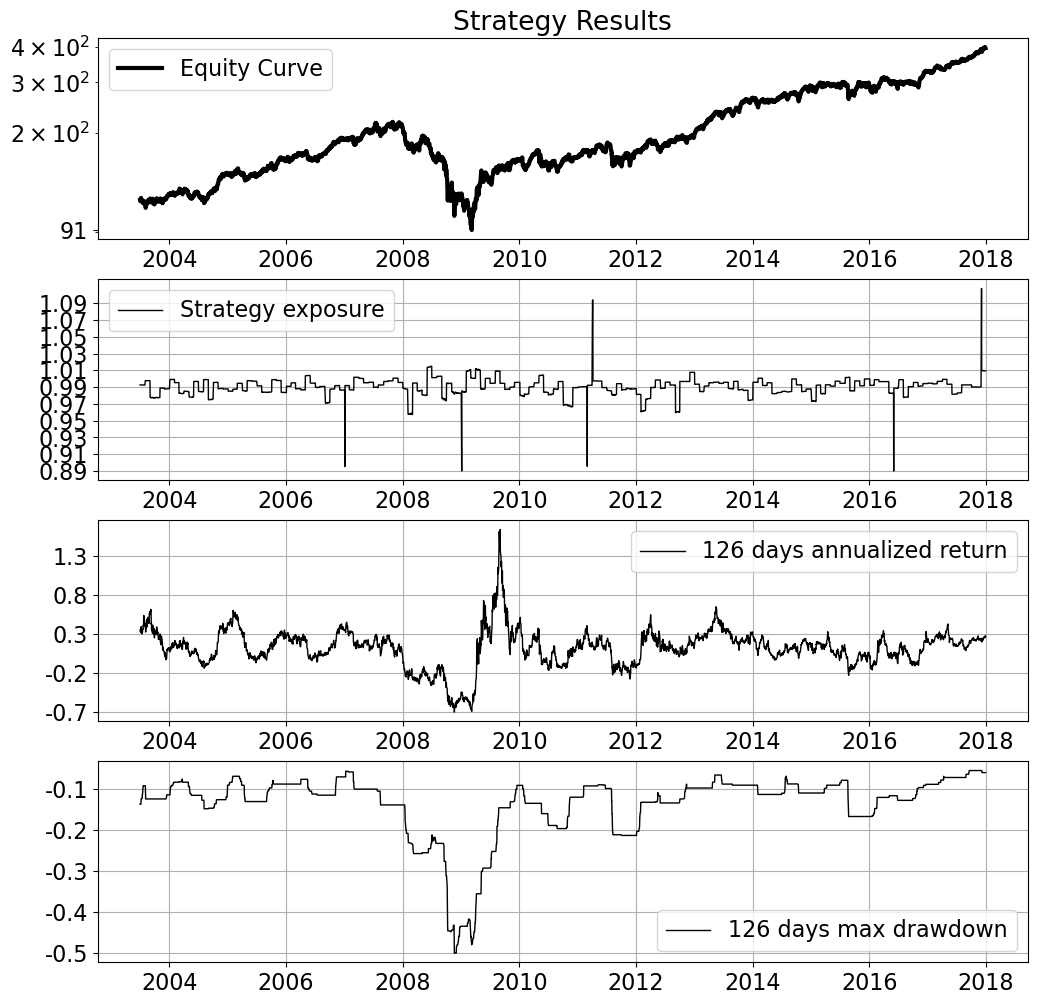

In [20]:

# Make a figure
fig = plt.figure(figsize=(12, 12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(411)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], 
        linestyle='-', 
        color='black',
        label='Equity Curve', linewidth=3.0)

# Set log scale
ax.set_yscale('log') 

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# Add legend and grid
ax.legend()
ax.grid(False)

# Second chart
ax = fig.add_subplot(412)
ax.plot(df['gross_leverage'], 
        label='Strategy exposure'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.02 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Third chart
ax = fig.add_subplot(413)
ax.plot(df['annualized'], 
        label='{} days annualized return'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.5 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fourth chart
ax = fig.add_subplot(414)
ax.plot(df['drawdown'], 
        label='{} days max drawdown'.format(calc_window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.1 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

# Add legend and grid
ax.legend()
ax.grid(True)


---